# **Module**

In [ ]:
# download modules
#!pip install --upgrade infomap
!pip install --upgrade unidecode
!pip install --upgrade textblob
!pip install --upgrade sastrawi
!pip install --upgrade tqdm
!pip install --upgrade wget
!pip install --upgrade dash
!pip install --upgrade igraph
!pip install --upgrade leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=a9e92029ba43ea326b92958792de6481adf668faed07cef13fcb68e43d0b7947
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.2 MB/s eta 0:00:00


In [ ]:
# import modules
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import re
import string
from unidecode import unidecode
from html import unescape
from tqdm import tqdm
import nltk
from nltk import word_tokenize
nltk.download('punkt')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import  Counter
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, html, dcc, Input, Output

import wget
import urllib.request
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
#from infomap import Infomap
import igraph as ig
import leidenalg as la
import nltk
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Data**
Data tweet seputar perbincangan agama islam yang diperoleh melalui proses *crawling* dari Twitter dengan berbagai macam keyword terkait yang dapat diakses pada *spreadsheet* berikut:

https://docs.google.com/spreadsheets/d/15lfv2HDYOyns_Z_fZ1QU39wbzxvxMiUT_v_k92UbyfY/edit?usp=sharing

## Load Data

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data
df = pd.read_csv('/content/drive/MyDrive/Berkas Skripsi/Data/Data_Agama.csv', low_memory=False)
print(df.shape)

(506386, 18)


## Basic Preprocessing

In [ ]:
# column filtering
df_baru = df[['screen_name','tweet','created_at']]
df_baru.head()

,screen_name,tweet,created_at
0,paoir,saya liberal! Meliberalkan diri dari tahayul b...,NaN
1,ab_sadewa,"Untuk mengurangi kemacetan di jakarta, mari ke...",2010-10-25
2,reszzjava,@firahermana nice tweets. Mungkin film itu bis...,NaN
3,D_Armalia,RT @luvditz: Liat dude herlino kayanya artis p...,NaN
4,Ayesaja,Tolong jelaskan mengapa Al Qur'an tdk bs memaj...,2010-12-07


In [ ]:
# handle missing value (column and row level)
kolom_null = df_baru.isna().sum()
baris_null = df_baru[df_baru.isna().any(axis=1)]

# column level
print(kolom_null)

print()

# row level
print('list index berisi Nan :', baris_null.index.tolist()[:5])
print(len(baris_null))

screen_name      498
tweet            105
created_at     56247
dtype: int64

list index berisi Nan : [0, 2, 3, 5, 6]
56247


In [ ]:
# remove missing value
df_clean = df_baru.dropna()
print(df_clean.shape)

(450139, 3)


In [ ]:
# remove data 2008
print('jumlah data tahun 2008:',len(df_clean[df_clean['created_at'].str.contains('2008')]))
df_clean = df_clean[~df_clean['created_at'].str.contains('2008')]

jumlah data tahun 2008: 3


## Data Based On Year

In [ ]:
# equalize the date format
df_clean['created_at'] = pd.to_datetime(df_clean['created_at'], infer_datetime_format=True, dayfirst=True)

# create new column contain only the year
df_clean['year'] = df_clean['created_at'].dt.year

unique_year = df_clean['year'].unique()
print('total terdapat',len(unique_year),'tahun')

total terdapat 11 tahun


In [ ]:
# sort by year
df_year = df_clean.sort_values(by='year', ascending=True)

# total data each year
df_count = pd.DataFrame({'year': df_year['year'].value_counts().index,
                         'count': df_year['year'].value_counts().values})
df_count['year'] = df_count['year'].astype('category')
df_count = df_count.sort_values(by='year')
df_count = df_count.reset_index(drop=True)
df_count

,year,count
0,2009,4058
1,2010,20380
2,2011,49107
3,2012,73436
4,2013,78468
5,2014,79930
6,2015,55425
7,2016,34091
8,2017,32450
9,2018,18777


In [ ]:
df_year.isnull().sum()

screen_name    0
tweet          0
created_at     0
year           0
dtype: int64

### Data Distribution Every Year

In [ ]:
# bar plot
fig = px.bar(df_count, x='year', y='count', text='count', color='year')

# figure layout & size
fig.update_layout(
    title='Amount of Data Each Year',
    xaxis_title='Year',
    yaxis_title='Quantity',
    autosize=False,
    width=1000,
    height=600,
    margin=dict(l=30, r=30, b=50, t=50))

fig.update_xaxes(type='category')
fig.show()

In [ ]:
# remove data in 2008
df_year = df_year.drop(df_year[df_year['year'] == 2008].index)

df_count = df_count.drop(df_count[df_count['year'] == 2008].index)
df_count = df_count.reset_index(drop=True)

In [ ]:
# this variable will be used frequently
all_year = df_year['year'].unique()

In [ ]:
# data based on year
def based_year(dataframe, year):
    data = dataframe[dataframe['year'] == year]
    return data

# call function
for year in all_year:
  globals()[f"df_{year}"] = based_year(df_year, year)

# show data for each year
for year in all_year:
  var_name = f'df_{year}'
  total_year = globals()[var_name]
  print(f'jumlah data pada tahun {year}: {total_year.shape[0]}')

jumlah data pada tahun 2009: 4058
jumlah data pada tahun 2010: 20380
jumlah data pada tahun 2011: 49107
jumlah data pada tahun 2012: 73436
jumlah data pada tahun 2013: 78468
jumlah data pada tahun 2014: 79930
jumlah data pada tahun 2015: 55425
jumlah data pada tahun 2016: 34091
jumlah data pada tahun 2017: 32450
jumlah data pada tahun 2018: 18777
jumlah data pada tahun 2019: 4014


# **Graf**
Data setiap tahunnya akan disusun menjadi graf tidak berarah (*undirected*) dengan metrik atau ukuran *degree*-nya yang menyatakan hubungan antara dua pengguna berupa *mention* dan *retweet*.

## Data Transformation
Perbedaan utama antara code "Mention Data" dengan "Isolated Edge" terletak pada jumlah *mention* yang ingin di seleksi.

### Mention Data

In [ ]:
# Function to extract user mentions in a tweet
def extract_mentions(text):
    mention = re.findall(r'@(\w{4,15})', text)
    return mention

# Function to get user mention data based on year
def mention_year(dataframe, year):
    data = dataframe[dataframe['year'] == year]
    # User data that mentions
    data_mention = []
    for _, row in data.iterrows():
        username = row['screen_name']
        mentions = extract_mentions(row['tweet'])
        for target in mentions:
            if username.lower() != target.lower():  # Exclude self-mentions
                data_mention.append({'username': username, 'mention': target, 'year': year})
    return data_mention

# Call function
for year in all_year:
    globals()[f"mention_{year}"] = pd.DataFrame(mention_year(df_year, year))

print('data mention dibagi per tahun')

data mention dibagi per tahun


In [ ]:
# list all mention data
mention_list = [var for var in globals() if var.startswith('mention_20')]

# merge all mention data every year
df_mention = pd.concat([globals()[var] for var in mention_list], ignore_index=False)
print(df_mention.shape)
df_mention.head()

(144640, 3)


,username,mention,year
0,daustralala,sigitt,2009
1,bobbywrahardjo,yosephine_ajeng,2009
2,raFiiicka,rosyholic,2009
3,raFiiicka,namasayayudi,2009
4,putifaried,weedhie,2009


### Isolated Edge

In [ ]:
# calculate the number of mentions
def count_mentions(mentions_list):
  return len(mentions_list)

# split the users in "username" column
def expand_mentions(row):
  mentioned = row['username']
  return [{'username': row['mention'], 'mentioned': mention, 'year': year} for mention in mentioned]

# mentioned user data based on year
def mentioned_year(dataframe, year):
  data = dataframe[dataframe['year'] == year]
  # user mentioned count
  mentioned = data.groupby('mention')['username'].agg(list).reset_index()
  mentioned['number_mentioned'] = mentioned['username'].apply(count_mentions)
  # filter the number of mentions
  sampel = mentioned[mentioned['number_mentioned'] > 1]
  # break the mention list into new rows with one user in each row
  expanded_mentions = sampel.apply(expand_mentions, axis=1)
  # combine them into a new dataframe
  data_mentioned = pd.DataFrame([username for mentions_list in expanded_mentions for username in mentions_list])

  return data_mentioned

# call function
for year in all_year:
  globals()[f"mentioned_{year}"] = pd.DataFrame(mentioned_year(df_mention, year))

print('data mention masing2 tahun berhasil difilter')

data mention masing2 tahun berhasil difilter


In [ ]:
# list all mentioned data
mentioned_list = [var for var in globals() if var.startswith('mentioned_20')]

# merge all mention data every year
df_mentioned = pd.concat([globals()[var] for var in mentioned_list], ignore_index=False)
print(df_mentioned.shape)
df_mentioned.head()

(71127, 3)


,username,mentioned,year
0,Aldy_SAS,dennyhidayat,2009
1,Aldy_SAS,OctaViyanita,2009
2,BerryVEE,rais_anwar,2009
3,BerryVEE,dapih,2009
4,Dennydrastic,mahbols,2009


### Top Mentioned Users

In [ ]:
# select the number of users mentioned
N = 15
mention_counts = df_mentioned['username'].value_counts().iloc[:N]

# horizontal bar plot
fig = px.bar(df_mentioned, x=mention_counts.values, y=mention_counts.index)

# figure layout & size
fig.update_layout(
    title='Top {} Users Mentioned'.format(N),
    xaxis_title='Number of Mentions',
    yaxis_title='User Mentioned',
    autosize=False,
    width=1200,
    height=600,
    margin=dict(l=30, r=30, b=50, t=50),
    bargap=0.5)

fig.update_traces(textposition='outside')
fig.show()

## Graph Building

In [ ]:
def graph_year(dataframe, year):
  data = dataframe[dataframe['year'] == year]
  # new directed graph variable
  G = nx.Graph()
  # add nodes and edges with direction
  for _, row in data.iterrows():
    G.add_node(row["username"])
    G.add_node(row["mentioned"])
    G.add_edge(row["username"], row["mentioned"])

  return G

# call the function
for year in all_year:
  globals()[f"graph_{year}"] = graph_year(df_mentioned, year)

print('graf berarah dibagi per tahun')

graf berarah dibagi per tahun


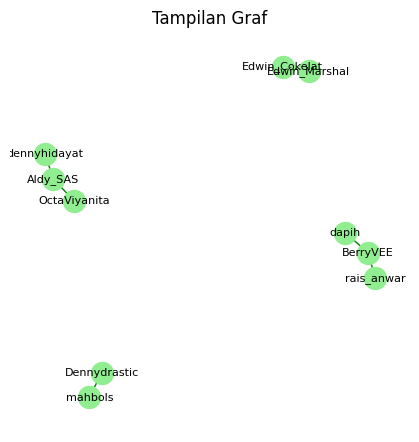

In [ ]:
sub_nodes = list(graph_2009.nodes)[:10]
sub_G = graph_2009.subgraph(sub_nodes)

plt.figure(figsize=(4, 4))
pos = nx.spring_layout(sub_G)
nx.draw(sub_G, pos, with_labels=True, node_size=250, node_color="lightgreen", font_size=8, edge_color="green")
plt.title("Tampilan Graf")
plt.show()

In [ ]:
def graph_distribution(graphs):
  data = []
  allyear = range(2009,2020)
  for graph, year in zip(graphs, allyear):
    data.append({
        'Tahun': year,
        'Simpul': graph.number_of_nodes(),
        'Sisi': graph.number_of_edges()
        })
  return pd.DataFrame(data)

graph_list = [globals()[var] for var in globals() if var.startswith('graph_20')]
df_graf = graph_distribution(graph_list)

x = ['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']

fig = go.Figure(data=[
    go.Bar(name='Simpul', x=x, y=df_graf['Simpul'], text=df_graf['Simpul'], textposition='auto'),
    go.Bar(name='Sisi', x=x, y=df_graf['Sisi'], text=df_graf['Sisi'], textposition='auto')
])
fig.update_layout(barmode='group', width= 1000, height=600)
fig.show()

In [ ]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.9 MB/s eta 0:00:00


# **Community Detection**
source :
1. https://networkx.org/documentation/stable/reference/algorithms/community.html
2. https://pypi.org/project/infomap/

## Louvain
Metode Louvain menggunakan pendekatan **modularity** untuk mendeteksi komunitas dalam jaringan. Modularity yang tinggi memiliki *edge* yang padat di dalam komunitas dan memiliki lebih sedikit *edge* yang menghubungkan komunitas-komunitas tersebut.

In [ ]:
'''
# community detection using the louvain method
def louvain_communities(graph):
  communities = nx.community.louvain_communities(graph, weight='None', seed=42)
  df_louvain = pd.DataFrame({'Id': [i+1 for i, _ in enumerate(communities)], 'Anggota': communities})
  df_louvain['Jumlah'] = df_louvain['Anggota'].apply(len)
  df_louvain = df_louvain.sort_values(by='Jumlah', ascending=False)
  return df_louvain

# apply louvain method to all graph data based on year
for year, graph in zip(all_year, graph_list):
  communities = louvain_communities(graph)
  globals()[f"louvain_{year}"] = communities

# show community detection results for each year
for year in all_year:
  var_name = f'louvain_{year}'
  total_louvain = globals()[var_name]
  print(f'jumlah komunitas pada tahun {year}: {total_louvain.shape[0]}')
'''

'\n# community detection using the louvain method\ndef louvain_communities(graph):\n  communities = nx.community.louvain_communities(graph, weight=\'None\', seed=42)\n  df_louvain = pd.DataFrame({\'Id\': [i+1 for i, _ in enumerate(communities)], \'Anggota\': communities})\n  df_louvain[\'Jumlah\'] = df_louvain[\'Anggota\'].apply(len)\n  df_louvain = df_louvain.sort_values(by=\'Jumlah\', ascending=False)\n  return df_louvain\n\n# apply louvain method to all graph data based on year\nfor year, graph in zip(all_year, graph_list):\n  communities = louvain_communities(graph)\n  globals()[f"louvain_{year}"] = communities\n\n# show community detection results for each year\nfor year in all_year:\n  var_name = f\'louvain_{year}\'\n  total_louvain = globals()[var_name]\n  print(f\'jumlah komunitas pada tahun {year}: {total_louvain.shape[0]}\')\n'

In [ ]:
# modularity method from gephi
lv_2009 = pd.read_csv('lou_2009.csv', delimiter=';')
lv_2010 = pd.read_csv('lou_2010.csv', delimiter=';')
lv_2011 = pd.read_csv('lou_2011.csv', delimiter=';')
lv_2012 = pd.read_csv('lou_2012.csv', delimiter=';')
lv_2013 = pd.read_csv('lou_2013.csv', delimiter=';')
lv_2014 = pd.read_csv('lou_2014.csv', delimiter=';')
lv_2015 = pd.read_csv('lou_2015.csv', delimiter=';')
lv_2016 = pd.read_csv('lou_2016.csv', delimiter=';')
lv_2017 = pd.read_csv('lou_2017.csv', delimiter=';')
lv_2018 = pd.read_csv('lou_2018 (no YouTube).csv', delimiter=';')
lv_2019 = pd.read_csv('lou_2019.csv', delimiter=';')

FileNotFoundError: [Errno 2] No such file or directory: 'lou_2009.csv'

In [ ]:
lv_list = [globals()[var] for var in globals() if var.startswith('lv_20')]

def gephi_louvain(table):
  data = table.groupby('Class')['Id'].apply(set).reset_index()
  data.columns = ['Id', 'Anggota']
  data['Jumlah'] = data['Anggota'].apply(len)
  data = data.sort_values(by='Jumlah', ascending=False)
  return data

for year, lv in zip(all_year, lv_list):
  communities = gephi_louvain(lv)
  globals()[f"louvain_{year}"] = communities

In [ ]:
louvain_list = [globals()[var] for var in globals() if var.startswith('louvain_20')]

In [ ]:
def top3_communities(data):
    louvain_com1 = generate_louvain_com(data, 1, year)
    louvain_com2 = generate_louvain_com(data, 2, year)
    louvain_com3 = generate_louvain_com(data, 3, year)

    return louvain_com1, louvain_com2, louvain_com3

def generate_louvain_com(data, i, year):
    louvain_topic = data[:3].reset_index(drop=True)
    community_keywords = {}
    for idx, row in louvain_topic.iterrows():
      community = row['Anggota']
      keywords = '|'.join(community)
      community_keywords[idx] = keywords

    # adjust the year
    df_new = df_year[df_year['year']== year]
    # community keyword search in "screen_name" column
    filter_screen = df_new[df_new['screen_name'].str.contains(community_keywords[i-1])]
    # community keyword search in "tweet" column
    filter_tweet = df_new[df_new['tweet'].str.contains(community_keywords[i-1])]
    louvain_com = pd.concat([filter_screen, filter_tweet], ignore_index=True)
    louvain_com['year'] = year
    louvain_com['id'] = i

    return louvain_com

for year, com in zip(all_year, louvain_list):
  communities = top3_communities(com)

  globals()[f"louvain_{year}_com1"] = communities[0]
  globals()[f"louvain_{year}_com2"] = communities[1]
  globals()[f"louvain_{year}_com3"] = communities[2]

## Leiden

In [ ]:
'''
data_ig = df_mentioned[df_mentioned['year']==2009]

edges = list(zip(data_ig['username'], data_ig['mentioned']))
g_09 = ig.Graph.TupleList(edges, directed=False)

ldc = la.find_partition(g_09, la.ModularityVertexPartition, seed=)

for i, community in enumerate(ldc):
  print(f"Komunitas {i + 1}: {', '.join(g_09.vs[community]['name'])}")

In [ ]:
# modularity method from gephi
ld_2009 = pd.read_csv('lei_2009.csv', delimiter=';')
ld_2010 = pd.read_csv('lei_2010.csv', delimiter=';')
ld_2011 = pd.read_csv('lei_2011.csv', delimiter=';')
ld_2012 = pd.read_csv('lei_2012.csv', delimiter=';')
ld_2013 = pd.read_csv('lei_2013.csv', delimiter=';')
ld_2014 = pd.read_csv('lei_2014.csv', delimiter=';')
ld_2015 = pd.read_csv('lei_2015.csv', delimiter=';')
ld_2016 = pd.read_csv('lei_2016.csv', delimiter=';')
ld_2017 = pd.read_csv('lei_2017.csv', delimiter=';')
ld_2018 = pd.read_csv('lei_2018.csv', delimiter=';')
ld_2019 = pd.read_csv('lei_2019.csv', delimiter=';')

In [ ]:
ld_list = [globals()[var] for var in globals() if var.startswith('ld_20')]

def gephi_leiden(table):
  data = table.groupby('Cluster')['Id'].apply(set).reset_index()
  data.columns = ['Id', 'Anggota']
  data['Jumlah'] = data['Anggota'].apply(len)
  data = data.sort_values(by='Jumlah', ascending=False)
  return data

for year, lv in zip(all_year, ld_list):
  communities = gephi_leiden(lv)
  globals()[f"leiden_{year}"] = communities

In [ ]:
leiden_list = [globals()[var] for var in globals() if var.startswith('leiden_20')]

In [ ]:
def top3_communities(data):
    leiden_com1 = generate_leiden_com(data, 1, year)
    leiden_com2 = generate_leiden_com(data, 2, year)
    leiden_com3 = generate_leiden_com(data, 3, year)

    return leiden_com1, leiden_com2, leiden_com3

def generate_leiden_com(data, i, year):
    leiden_topic = data[:3].reset_index(drop=True)
    community_keywords = {}
    for idx, row in leiden_topic.iterrows():
      community = row['Anggota']
      keywords = '|'.join(community)
      community_keywords[idx] = keywords

    # adjust the year
    df_new = df_year[df_year['year']== year]
    # community keyword search in "screen_name" column
    filter_screen = df_new[df_new['screen_name'].str.contains(community_keywords[i-1])]
    # community keyword search in "tweet" column
    filter_tweet = df_new[df_new['tweet'].str.contains(community_keywords[i-1])]
    leiden_com = pd.concat([filter_screen, filter_tweet], ignore_index=True)
    leiden_com['year'] = year
    leiden_com['id'] = i

    return leiden_com

for year, com in zip(all_year, leiden_list):
  communities = top3_communities(com)

  globals()[f"leiden_{year}_com1"] = communities[0]
  globals()[f"leiden_{year}_com2"] = communities[1]
  globals()[f"leiden_{year}_com3"] = communities[2]

## Label Propagation
Metode Label Propagation bekerja dengan cara memperbarui atau mengupdate **label** dari setiap simpul secara iteratif menjadi label yang paling umum di antara tetangganya, dimulai dengan memberikan label unik pada setiap simpul, kemudian mengupdate label-label tersebut secara berulang hingga label-label tersebut konvergen (tidak ada perubahan).

In [ ]:
# community detection using the label propagation method
def labelpro_communities(graph):
  communities = nx.community.label_propagation_communities(graph)
  df_labelpro = pd.DataFrame({'Id': [i+1 for i, _ in enumerate(communities)], 'Anggota': communities})
  df_labelpro['Jumlah'] = df_labelpro['Anggota'].apply(len)
  df_labelpro = df_labelpro.sort_values(by='Jumlah', ascending=False)
  return df_labelpro

# apply label propagation method to all graph data based on year
for year, graph in zip(all_year, graph_list):
  communities = labelpro_communities(graph)
  globals()[f"labelpro_{year}"] = communities

# show community detection results for each year
for year in all_year:
  var_name = f'labelpro_{year}'
  total_labelpro = globals()[var_name]
  print(f'jumlah komunitas pada tahun {year}: {total_labelpro.shape[0]}')

In [ ]:
labelpro_list = [globals()[var] for var in globals() if var.startswith('labelpro_20')]

In [ ]:
def top3_communities(data):
    labelpro_com1 = generate_labelpro_com(data, 1)
    labelpro_com2 = generate_labelpro_com(data, 2)
    labelpro_com3 = generate_labelpro_com(data, 3)

    return labelpro_com1, labelpro_com2, labelpro_com3

def generate_labelpro_com(data, i):
    labelpro_topic = data[:3].reset_index(drop=True)
    community_keywords = {}
    for idx, row in labelpro_topic.iterrows():
      community = row['Anggota']
      keywords = '|'.join(community)
      community_keywords[idx] = keywords

    # adjust the year
    df_new = df_year[df_year['year']== year]
    # community keyword search in "screen_name" column
    filter_screen = df_clean[df_clean['screen_name'].str.contains(community_keywords[i-1])]
    # community keyword search in "tweet" column
    filter_tweet = df_clean[df_clean['tweet'].str.contains(community_keywords[i-1])]
    labelpro_com = pd.concat([filter_screen, filter_tweet], ignore_index=True)
    labelpro_com['year'] = year
    labelpro_com['id'] = i

    return labelpro_com

for year, com in zip(all_year, labelpro_list):
  communities = top3_communities(com)

  globals()[f"labelpro_{year}_com1"] = communities[0]
  globals()[f"labelpro_{year}_com2"] = communities[1]
  globals()[f"labelpro_{year}_com3"] = communities[2]

## Infomap
Metode Infomap adalah metode berbasis **informasi** yang menekankan aliran dalam jaringan. Informasi yang dimaksud dapat mengacu pada bagaimana elemen-elemen dalam jaringan berinteraksi atau berhubungan satu sama lain.

In [ ]:
# community detection using the infomap method
def im_communities(graph):
  mapping = im.add_networkx_graph(graph)
  im.run()
  # create user id data
  user = dict(mapping)
  df_user = pd.DataFrame(list(user.items()), columns=['Id', 'Username'])
  # create community id data
  communities = []
  for node in im.nodes:
    communities.append((node.node_id, node.module_id))
  df_communities = pd.DataFrame(communities, columns=['node_id', 'module_id'])
  # create community data and users in it according to their own id
  df_merge = df_communities.merge(df_user, left_on='node_id', right_on='Id')
  df_grouped = df_merge.groupby('module_id')['Username'].apply(set).reset_index()
  df_grouped = df_grouped.rename(columns={'module_id': 'Id', 'Username': 'Anggota'})
  df_grouped['Jumlah'] = df_grouped['Anggota'].apply(len)
  df_grouped = df_grouped.sort_values(by='Jumlah', ascending=False)

  return df_grouped, im

# apply infomap method to all graph data based on year
for year, graph in zip(all_year, graph_list):
  # create an Infomap class object to jump into community detection
  im = Infomap(silent=True)
  communities, im = im_communities(graph)
  globals()[f"infomap_{year}"] = communities

# show community detection results for each year
for year in all_year:
  var_name = f'infomap_{year}'
  total_infomap = globals()[var_name]
  print(f'jumlah komunitas pada tahun {year}: {total_infomap.shape[0]}')

In [ ]:
infomap_list = [globals()[var] for var in globals() if var.startswith('infomap_20')]

In [ ]:
def top3_communities(data):
    infomap_com1 = generate_infomap_com(data, 1)
    infomap_com2 = generate_infomap_com(data, 2)
    infomap_com3 = generate_infomap_com(data, 3)

    return infomap_com1, infomap_com2, infomap_com3

def generate_infomap_com(data, i):
    infomap_topic = data[:3].reset_index(drop=True)
    community_keywords = {}
    for idx, row in infomap_topic.iterrows():
        community = row['Anggota']
        keywords = '|'.join(community)
        community_keywords[idx] = keywords

    # adjust the year
    df_new = df_year[df_year['year']== year]
    # community keyword search in "screen_name" column
    filter_screen = df_clean[df_clean['screen_name'].str.contains(community_keywords[i-1])]
    # community keyword search in "tweet" column
    filter_tweet = df_clean[df_clean['tweet'].str.contains(community_keywords[i-1])]
    infomap_com = pd.concat([filter_screen, filter_tweet], ignore_index=True)
    infomap_com['year'] = year
    infomap_com['id'] = i

    return infomap_com

for year, com in zip(all_year, infomap_list):
  communities = top3_communities(com)

  globals()[f"infomap_{year}_com1"] = communities[0]
  globals()[f"infomap_{year}_com2"] = communities[1]
  globals()[f"infomap_{year}_com3"] = communities[2]

# **Content Analysis**

## Cleansing Tweet
membersihkan data teks awal untuk mempermudah penentuan topik yang dibahas pada seluruh komunitas yang ada.
- Menyingkirkan simbol-simbol dan karakter
- Menyingkirkan *slang* atau singkatan
- Menyingkirkan *stopword*
- *Stemming* (jika perlu)

source : https://github.com/taudataid/eLearning/tree/master/data

In [ ]:
# load slang
url = 'https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/main/data/slang.dic'
response = urllib.request.urlopen(url)
slang_id = eval(response.read())

print("jumlah slang: ", len(slang_id))

jumlah slang:  1629


In [ ]:
slang_tambahan = {'kh': 'kah', 'kapir': 'kafir', 'ummat': 'umat', 'alloh': 'allah', 'orangorang': 'orang', 'orang2': 'orang', 'sekuler': 'sekular', 'yaa': 'ya',
                  'sirik': 'syirik', 'musrik': 'musyrik', 'prcya': 'percaya', 'percya': 'percaya', 'pcya': 'percaya', 'kmu': 'kamu', 'isteri': 'istri', 'tertawa': 'tawa',
                  'menikah': 'nikah', 'perbuatanperbuatan': 'perbuatan', 'aqidah': 'akidah', 'barangsiapa': 'barang siapa', 'sorga': 'surga', 'syurga': 'surga',
                  'sama2': 'sama-sama', 'syaitan': 'setan', 'msuk': 'masuk', 'mendegardengar': 'mendengar', 'sebaik2':'sebaik-baik', 'pdmu': 'padamu', 'mrka': 'mereka',
                  'nerakasiksa': 'siksa neraka', 'pintu2': 'pintu-pintu', 'ustaz': 'ustadz', 'ustad': 'ustadz', 'brg': 'barang', 'menjwb' : 'menjawab', 'apa2': 'apa-apa',
                  'qs': 'quran surat', 'dgn': 'dengan', 'dg': 'dengan', 'praktik': 'praktek', 'shalat': 'sholat', 'solat': 'sholat', 'bapa': 'bapak', 'bsok': 'besok',
                  'bagamana': 'bagaimana', 'ahlusunah': 'ahlussunnah', 'ahlus' : 'ahlussunnah', 'ahlul': 'ahlussunnah', 'salehah': 'solehah', 'solihah': 'solehah',
                  'salihah': 'solehah', 'hr': 'hadist riwayat', 'redho': 'ridho', 'rido': 'ridho', 'ridha': 'ridho', 'waljamaah': 'wal jamaah', 'uud': 'undang-undang dasar',
                  'polri': 'polisi', 'kepolisian': 'polisi', 'silakan': 'silahkan', 'rosul': 'rasul', 'naamaa': 'nama', 'prof': 'professor', 'ri': 'republik indonesia',
                  'qur': 'quran', 'ruf': 'maruf', 'brang': 'barang'}
slang_id.update(slang_tambahan)

print("jumlah slang : ", len(slang_id))

jumlah slang :  1692


In [ ]:
# load stopword
url = 'https://raw.githubusercontent.com/taudataanalytics/taudata-Academy/main/data/stopwords_id.txt'
response = urllib.request.urlopen(url)
stopword_id = response.read().decode('utf-8').split('\n')

print("jumlah stopword: ", len(stopword_id))

jumlah stopword:  758


In [ ]:
stopword_tambahan = set(['a', 'at', 'al', 'ah', 'an', 'aa', 'ala', 'ayo', 'ae', 'atm', 'aje', 'ati', 'and', 'aduh', 'alaihi', 'aamiin', 'anggap', 'apapun', 'added', 'ambil', 'anjing', 'alhamdulillah',
                         'b', 'be', 'bi', 'by', 'bu', 'bb', 'bae', 'bin', 'brt', 'bit', 'been', 'bawa', 'banget', 'bikin', 'bareng', 'besok', 'backsound', 'biologi', 'bilang', 'biar', 'bicara', 'busana', 'bukalapak',
                         'c', 'cont', 'ci', 'co', 'cc', 'cus', 'com', 'cek', 'cnn', 'caya', 'club', 'care', 'cari', 'carbon', 'copy', 'cium', 'cinematic', 'chirpstorycomli', 'chirpstory', 'chirpified',
                         'd', 'depok', 'da', 'do', 'deh', 'dih', 'dar', 'dear', 'dlvr',
                         'e', 'eh', 'ente', 'erti', 'enak', 'engkau',
                         'f', 'for', 'facebook', 'follow', 'fisika',
                         'g', 'ga', 'gs', 'gl', 'go', 'gym', 'gamis', 'gera', 'goo', 'gitu',
                         'h', 'hahaha', 'haha', 'ha', 'has', 'hai', 'he', 'hot', 'hell', 'huku', 'hahart', 'harap', 'halobca', 'hadiah',
                         'i', 'iya', 'iyaa', 'im', 'ih', 'is', 'iku', 'ipa', 'in', 'id', 'it', 'ing', 'ihiks', 'instagram',
                         'j', 'jam',
                         'k', 'kah', 'khe', 'ko', 'koe', 'kom', 'kak', 'ki', 'ku', 'kela', 'kayak', 'kasih', 'kecuali', 'kadang', 'kompas', 'kemarin', 'kimia',
                         'l', 'li', 'ln', 'ly', 'lil', 'live', 'liked', 'lihat', 'loh', 'lho', 'langsung', 'lupa',
                         'm', 'mi', 'min', 'moga', 'mn', 'mah', 'mas', 'mbak', 'my', 'mu', 'muh', 'mh', 'md','mk', 'm17', 'mtw', 'me', 'mari', 'milik', 'melulu', 'maksud', 'metrotvn',
                         'n', 'neh', 'nya', 'neng', 'news', 'nnu', 'n1', 'n2', 'n7', 'nn', 'ng', 'now', 'not',
                         'o', 'others', 'orang', 'om', 'oh', 'on', 'out', 'of', 'ow', 'or', 'opo', 'okz',
                         'p', 'ps', 'pt', 'pic', 'pas', 'play', 'path', 'post', 'pakai', 'proses', 'pulsa', 'playlist',
                         'q', 'qs',
                         'r', 'rp', 'rt', 'ra', 'ri', 'rs', 'ruf', 'rol', 'read', 'rabb', 'rabbku', 'retweeted', 'rejoice', 'retweet', 'retweets',
                         's', 'si', 'so', 'sh', 'st', 'saw', 'sih', 'sok', 'sta', 'stat', 'statu', 'situ', 'syar', 'sesuai', 'syahlaa', 'setyarini', 'seperti', 'sama', 'sing', 'shampoo', 'sungguh', 'semoga', 'silahkan', 'sebentar', 'sesungguhnya', 'shallallahu',
                         't', 'ta', 'tmi', 'tik', 'titit', 'to', 'tol', 'teen', 'toll', 'the', 'tuk', 'tah', 'this', 'tega', 'tiada', 'terima', 'terlibat', 'tuju', 'tinyurl', 'tweet', 'twitter', 'terkadang', 'timeline', 'tinggal', 'tribunnews',
                         'u', 'uas', 'uts', 'un', 'us', 'udah',
                         'v', 'via', 'video', 'vs', 'voucher',
                         'w', 'wl', 'ws', 'wae', 'wa', 'wal', 'wib', 'with', 'wkwkwk',
                         'x', 'xp',
                         'y', 'ya', 'ye', 'yee', 'yah', 'yanti', 'youtu', 'youtube', 'youtube9tkqntw3wla',
                         'z',
                         '9a', '5a', '8a', '1700an', 'c95cw_ndtfg'])
stopword_id = set(stopword_id).union(stopword_tambahan)

print("jumlah stopword: ", len(stopword_id))

jumlah stopword:  1073


In [ ]:
def cleaning_text(text):
  # menghapus url
  url_pattern = re.compile(r'(\w+:\/\/\S+)')
  text = url_pattern.sub(' ', text)
  # menghapus hashtag
  hashtag_pattern = re.compile(r'#\w+\b')
  text = hashtag_pattern.sub(' ', text)
  # menghapus nama pengguna twitter (memuat "@")
  username_pattern = re.compile(r'@\w+\b\s*')
  text = username_pattern.sub(' ', text)
  # menghapus angka
  text = re.sub(r'\b\d+\b|[^\w\s]', ' ', text)
  # menghapus simbol
  symbol_pattern = re.compile(r'[^\w\s]+')
  text = symbol_pattern.sub(' ', text)
  # menghapus karakter yang tidak diperlukan (tergantung media sosial)
  text = re.sub(r'\n', ' ', text)
  text = re.sub(r'\r', ' ', text)
  text = re.sub(r'&\w+', ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()
  # menangani huruf kapital dan spasi
  text = unidecode(unescape(text.lower()))
  return text

def remove_stopword(text):
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w in stopword_id]
  return ' '.join(filtered_sentence)

# this process is very time-consuming, so we will skip it
def stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return stemmer.stem(text)

def remove_slang(text):
  text = ''.join(slang_id[p] if p in slang_id else p for p in re.split(r'(\W+)', text))
  return text

def preprocess(text):
  # cleaning text and lowercase
  output = cleaning_text(text)
  # remove slang
  output = remove_slang(output)
  # stemming and lemmatization
  #output = stemming(output)
  # remove stopwords
  output = remove_stopword(output)

  return output

## N-Gram

In [ ]:
def tokenization(dataframe):
  texts = dataframe['clean_tweet']
  tokens = [token for text in texts for token in text.split()]
  return tokens

In [ ]:
def top3_bigram_communities(dataframe):
  louvain_bigram1 = bigram_communities(dataframe, 1, year)
  louvain_bigram2 = bigram_communities(dataframe, 2, year)
  louvain_bigram3 = bigram_communities(dataframe, 3, year)

  return louvain_bigram1, louvain_bigram2, louvain_bigram3

def bigram_communities(dataframe, i, year):
  data = dataframe[dataframe['id']== i]
  data = data[data['year']== year]
  ngram = tokenization(data)
  bigram = (pd.Series(nltk.ngrams(ngram, 2)).value_counts())[:20]

  data_bigram = []

  for pair, count in bigram.items():
    data_bigram.append({'bigram': pair, 'count': count})

  df_bigram = pd.DataFrame(data_bigram)
  df_bigram['year'] = year
  df_bigram['id'] = i

  return df_bigram

In [ ]:
def top3_trigram_communities(dataframe):
  louvain_trigram1 = trigram_communities(dataframe, 1, year)
  louvain_trigram2 = trigram_communities(dataframe, 2, year)
  louvain_trigram3 = trigram_communities(dataframe, 3, year)

  return louvain_trigram1, louvain_trigram2, louvain_trigram3

def trigram_communities(dataframe, i, year):
  data = dataframe[dataframe['id']== i]
  data = data[data['year']== year]
  ngram = tokenization(data)
  trigram = (pd.Series(nltk.ngrams(ngram, 3)).value_counts())[:10]

  data_trigram = []

  for pairs, counts in trigram.items():
    data_trigram.append({'trigram': pairs, 'count': counts})

  df_trigram = pd.DataFrame(data_trigram)
  df_trigram['year'] = year
  df_trigram['id'] = i

  return df_trigram

### Top 3 Communities

In [ ]:
# merge each of the three community data years into one dataset
def combine_communities(com_id):
    com_variables = [f"louvain_{year}_{com_id}" for year in all_year]
    com_dataframes = [globals()[var] for var in com_variables]

    # merge all dataframes in the list vertically
    louvain_allyear_com = pd.concat(com_dataframes, ignore_index=True)

    # cleansing tweet for the specified louvain community
    louvain_allyear_com['clean_tweet'] = louvain_allyear_com['tweet'].apply(preprocess)

    return louvain_allyear_com

def top3_combine_communities(com1, com2, com3):
    louvain_combined1 = combine_communities(com1)
    louvain_combined2 = combine_communities(com2)
    louvain_combined3 = combine_communities(com3)

    return louvain_combined1, louvain_combined2, louvain_combined3

# call the function
louvain_allyear_com1, louvain_allyear_com2, louvain_allyear_com3 = top3_combine_communities('com1', 'com2', 'com3')

# concat all years of community data into one dataframe
all_louvain = pd.concat([louvain_allyear_com1, louvain_allyear_com2, louvain_allyear_com3], ignore_index=True)

In [ ]:
# call the bigram function
for year in all_year:
  ngrams = top3_bigram_communities(all_louvain)

  globals()[f"louvain1_bigram_{year}"] = ngrams[0]
  globals()[f"louvain2_bigram_{year}"] = ngrams[1]
  globals()[f"louvain3_bigram_{year}"] = ngrams[2]

# call the trigram function
for year in all_year:
  ngrams = top3_trigram_communities(all_louvain)

  globals()[f"louvain1_trigram_{year}"] = ngrams[0]
  globals()[f"louvain2_trigram_{year}"] = ngrams[1]
  globals()[f"louvain3_trigram_{year}"] = ngrams[2]

In [ ]:
'''
def combine_ngram(n_gram):
  data_list = []
  for id in range(1, 4):
    for year in all_year:
      data_variable_name = f'louvain{id}_{n_gram}_{year}'
      data = globals()[data_variable_name]
      data_list.append(data)

  return pd.concat(data_list, ignore_index=True)

# bigram
all_louvain_bigram = combine_ngram("bigram")
# trigram
all_louvain_trigram = combine_ngram("trigram")
'''

'\ndef combine_ngram(n_gram):\n  data_list = []\n  for id in range(1, 4):\n    for year in all_year:\n      data_variable_name = f\'louvain{id}_{n_gram}_{year}\'\n      data = globals()[data_variable_name]\n      data_list.append(data)\n\n  return pd.concat(data_list, ignore_index=True)\n\n# bigram\nall_louvain_bigram = combine_ngram("bigram")\n# trigram\nall_louvain_trigram = combine_ngram("trigram")\n'

### Bigram & Trigram

In [ ]:
'''
app = Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='community-id',
        options=[{'label': i, "value": i} for i in all_louvain_bigram.id.unique()],
        value=all_louvain_bigram.id.unique()[0],
        placeholder='Pilih Id Komunitas'
    ),
    dcc.Dropdown(
        id='community-year',
        options=[{'label': i, "value": i} for i in all_louvain_bigram.year.unique()],
        value=all_louvain_bigram.year.unique()[0],
        placeholder='Pilih Tahun'
    ),
    dcc.Graph(id='bigram')
])

@app.callback(
    Output('bigram', 'figure'),
    [Input('community-id', 'value'),
     Input('community-year', 'value')]
)
def bigram_output(id, year):
    # filter data based on selected id and year
    df_bigram = all_louvain_bigram[(all_louvain_bigram['id'] == id) & (all_louvain_bigram['year'] == year)]
    df_bigram['bigram'] = df_bigram['bigram'].apply(lambda x: "('{}', '{}')".format(x[0], x[1]))

    # Horizontal bar plot
    fig = px.bar(df_bigram, x='count', y='bigram')

    # Figure layout & size
    fig.update_layout(
        title='20 Frequently Occurring Bigrams',
        xaxis_title='Number of Bigram Occurred',
        yaxis_title='Bigram',
        autosize=False,
        width=1400,
        height=800,
        margin=dict(l=30, r=30, b=50, t=50),
        bargap=0.5
    )
    fig.update_traces(textposition='outside')
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)
'''

In [ ]:
'''
app = Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='community-id',
        options=[{'label': i, "value": i} for i in all_louvain_bigram.id.unique()],
        value=all_louvain_bigram.id.unique()[0],
        placeholder='Pilih Id Komunitas'
    ),
    dcc.Dropdown(
        id='community-year',
        options=[{'label': i, "value": i} for i in all_louvain_bigram.year.unique()],
        value=all_louvain_bigram.year.unique()[0],
        placeholder='Pilih Tahun'
    ),
    dcc.Graph(id='trigram')
])

@app.callback(
    Output('trigram', 'figure'),
    [Input('community-id', 'value'),
     Input('community-year', 'value')]
)
def bigram_output(id, year):
    # filter data based on selected id and year
    df_trigram = all_louvain_trigram[(all_louvain_trigram['id'] == id) & (all_louvain_trigram['year'] == year)]
    df_trigram['trigram'] = df_trigram['trigram'].apply(lambda x: "('{}', '{}', '{}')".format(x[0], x[1], x[2]))

    # Horizontal bar plot
    fig = px.bar(df_trigram, x='count', y='trigram')

    # figure layout & size
    fig.update_layout(
        title='10 Frequently Occuring Trigrams',
      xaxis_title='Number of Trigram Occured',
      yaxis_title='Trigram',
      autosize=False,
      width=1400,
      height=800,
      margin=dict(l=30, r=30, b=50, t=50),
      bargap=0.5
      )
    fig.update_traces(textposition='outside')
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)
'''

## Hashtag

In [ ]:
final_data = louvain_allyear_com3[louvain_allyear_com3['year']==2018]

In [ ]:
# dictionary to store hashtags
HT = {'hashtags': []}
count = 0
getHashTags = re.compile(r"#(\w+)")

# find hashtags
for i, d in enumerate(final_data['tweet']):
  hashtags = re.findall(getHashTags, d)
  TG = ['#' + tag.strip().lower().replace('[^a-z\s#]', '') for tag in hashtags if len(tag.strip()) > 2]
  HT['hashtags'].append(TG)
  count += len(TG)

# hashtag count
hashtag_unique = set()
for tags in HT['hashtags']:
  hashtag_unique.update(tags)

print('ditemukan {} hashtag berbeda'.format(len(hashtag_unique)))

ditemukan 219 hashtag berbeda


In [ ]:
# hashtag count data
df_tag = pd.DataFrame({'kategori': [x for t in HT['hashtags'] for x in t]}).value_counts().reset_index()
df_tag.columns = ['hashtag', 'count']
df_tag.head(20)

,hashtag,count
0,#hijrahbersamajokowi,18
1,#2019gantipresiden,13
2,#manfaatdanadesa,12
3,#saveibunuril,12
4,#jokowilagi,11
5,#2019tetapjokowi,10
6,#01jokowilagi,8
7,#padatkaryatunai,8
8,#jokowi2periode,7
9,#kabar,7


In [ ]:
# select the number of hashtags
N = 25

# horizontal bar plot
fig = px.bar(df_tag[:N], y='hashtag', x='count',
             text='count')

# figure layout & size
fig.update_layout(
    title='Top {} Hashtags'.format(N),
    xaxis_title='Number of Hashtags',
    yaxis_title='Hashtag',
    autosize=False,
    width=1400,
    height=800,
    margin=dict(l=30, r=30, b=50, t=50),
    bargap=0.5)

fig.update_traces(textposition='outside')
fig.show()

## WordCloud

In [ ]:
# load font
url = "https://github.com/SalikFillah/Sentiment-Analysis/raw/main/Comfortaa-Bold.ttf"
filename = wget.download(url)

In [ ]:
# important
final_data = louvain_allyear_com3[louvain_allyear_com3['year']==2018]
final_data.head()

,screen_name,tweet,created_at,year,id,clean_tweet
18106,Metro_TV,Cahaya Hati: Berpuasa dari Segi Hukum metrotvn...,2018-05-19,2018,3,cahaya hati berpuasa segi hukum nbw7qo3b k0z1u...
18107,TJsecondoutdoor,Kelakuan pendukung pemerintah ya yg kaya gini ...,2018-05-16,2018,3,kelakuan pendukung pemerintah kaya berbuat keb...
18108,KSPgoid,"2. \""Saya ingin menyampaikan dukacita yang men...",2018-12-23,2018,3,dukacita mendalam korban provinsi banten seran...
18109,NurSyahbana9,ISLAM PEMAAF BUKAN PEMARAH\n\nNU: Tak Perlu Ja...,2018-04-03,2018,3,islam pemaaf pemarah jalur hukum sukmawati maa...
18110,ElisyaUgm,Harus siap menjadi pendamping @jokowi dan menj...,2018-01-13,2018,3,pendamping penjaga ulama ahlussunnah sunah jamaah


In [ ]:
# store all tweet and tokenized them
all_tweets = ' '.join(final_data['clean_tweet'])
tokens = word_tokenize(all_tweets)

# count the frequency
word_freq = Counter(tokens)

# display frequently occuring words
most_common_words = word_freq.most_common(10)
print(most_common_words)

[('hukum', 296), ('presiden', 174), ('ukhuwah', 96), ('jokowi', 94), ('indonesia', 70), ('desa', 67), ('rakyat', 61), ('ulama', 56), ('islamiyah', 56), ('negara', 47)]


In [ ]:
# displays the most words

allWords = ' '.join( [twts for twts in final_data['clean_tweet']] )
font = '/content/Comfortaa-Bold.ttf'
wordCloud = WordCloud(background_color = "white",
                      font_path = font,
                      width = 1600,
                      height = 900,
                      max_words = 50,
                      colormap = 'Spectral').generate(allWords)
plt.figure(figsize = (16,8))
plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# **Visualization**
**Gephi** adalah software open-source untuk memvisualisasikan dan menganalisis graf yang besar. Selain itu, **Gephi** juga dilengkapi dengan beberapa algoritma deteksi komunitas yang telah diimplementasikan sebelumnya.

In [ ]:
def contains_keywords(text, keywords):
  return any(keyword in text for keyword in keywords)

# keyword topik "islam_umum"
keyword1 = ['telapak', 'kaki', 'ibu', 'sedekah', 'hadist', 'riwayat', 'bukhari', 'muslim', 'tirmidzi', 'khalid', 'basalamah', 'ahmad', 'zainuddin', 'abdul', 'somad', 'adi', 'hidayat', 'erwandi', 'tarmizi', 'salim', 'fillah']

df_umum = all_louvain[all_louvain['clean_tweet'].apply(lambda text: contains_keywords(text, keyword1))]
print('jumlah data topik islam_umum :', len(df_umum))

# keyword topik "islam_politik"
keyword2 = ['poligami', 'pemerintah', 'dewan', 'perwakilan', 'komisi', 'pemberantas', 'korupsi', 'politik', 'partai', 'keadilan', 'sejahtera', 'poligami', 'sby', 'prabowo', 'jokowi', 'ahok', 'debat', 'capres', 'narkotika', 'psikotropika', 'presiden', 'ibukota', 'hak', 'asasi']

df_politik = all_louvain[all_louvain['clean_tweet'].apply(lambda text: contains_keywords(text, keyword2))]
print('jumlah data topik islam_politik :', len(df_politik))

# keyword topik "islam_konservatisme"
keyword3 = ['khilafah', 'ahmadiyah', 'front', 'pembela', 'majelis', 'ulama', 'nahdatul', 'jaringan', 'liberal', 'sepilis', 'syiah', 'hti', 'hizbut', 'tahrir', 'ite', 'gnpf']

df_konservatisme = all_louvain[all_louvain['clean_tweet'].apply(lambda text: contains_keywords(text, keyword3))]
print('jumlah data topik islam_konservatisme :', len(df_konservatisme))

jumlah data topik islam_umum : 12997
jumlah data topik islam_politik : 12314
jumlah data topik islam_konservatisme : 7550


In [ ]:
freq_umum = df_umum['year'].value_counts().sort_index().reset_index()
freq_umum.columns = ['date', 'frequency']
freq_umum['kategori'] = 'islam_umum'
freq_umum

freq_politik = df_politik['year'].value_counts().sort_index().reset_index()
freq_politik.columns = ['date', 'frequency']
freq_politik['kategori'] = 'islam_politik'
freq_politik

freq_kons = df_konservatisme['year'].value_counts().sort_index().reset_index()
freq_kons.columns = ['date', 'frequency']
freq_kons['kategori'] = 'islam_konservatif'
freq_kons

freq_islam = pd.concat([freq_umum, freq_politik, freq_kons], ignore_index=True)

In [ ]:
fig = px.line(freq_islam, x="date", y="frequency", color='kategori', symbol='kategori',
              title='Frekuensi Tweet',
              line_shape='spline')
fig.update_layout(xaxis=dict(tickmode='linear',dtick='M12',tickformat="%Y"),
                  width=1000, height=600
    )
fig.show()

# **Notebook**





variabel yang tidak terdefinisi dalam cell, namun ada pada sistem :
1.   **df_2009** s.d. **df_2019**
2.   **mention_2009** s.d. **mention_2019**
3.   **mentioned_2009** s.d. **mentioned_2019**
4.   **graph_2009** s.d. **graph_2019**
5.   **louvain_2019** s.d. **louvain_2019**
6.   **labelpro_2009** s.d. **labelpro_2019**
7.   **infomap_2009** s.d. **infomap_2019**
8.   **louvain_2009_com1** s.d. **louvain_2019_com3**
9.   **labelpro_2009_com1** s.d. **labelpro_2019_com3**
10.  **infomap_2009_com1** s.d. **infomap_2019_com3**
11. **louvain bigram** (berlaku juga sebaliknya untuk **trigram**)
- **louvain1_bigram_2009** s.d. **louvain1_bigram_2019**
- **louvain2_bigram_2009** s.d. **louvain2_bigram_2019**
- **louvain3_bigram_2009** s.d. **louvain3_bigram_2019**
12. **label propagation bigram** (berlaku juga sebaliknya untuk **trigram**)
- **labelpro1_bigram_2009** s.d. **labelpro1_bigram_2019**
- **labelpro2_bigram_2009** s.d. **labelpro2_bigram_2019**
- **labelpro3_bigram_2009** s.d. **labelpro3_bigram_2019**
13. **infomap bigram** (berlaku juga sebaliknya untuk **trigram**)
- **infomap1_bigram_2009** s.d. **infomap1_bigram_2019**
- **infomap2_bigram_2009** s.d. **infomap2_bigram_2019**
- **infomap3_bigram_2009** s.d. **infomap3_bigram_2019**




## *Code Bin*

In [ ]:
# save to gexf file
gexf_file = "graph_2018.gexf"#
nx.write_gexf(graph_2018, gexf_file)

# save to csv file
#all_louvain.to_csv('Top3_Komunitas_Louvain_Setiap_Tahun.csv', index=False)

# download the data
from google.colab import files
#files.download('graph_2009.gexf')
#files.download('Top3_Komunitas_Louvain_Setiap_Tahun.csv')
files.download('graph_2018.gexf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# view the iteration
#data['clean_tweet'] = ''
#for idx, post in tqdm(data.iterrows()):
  #data[idx, 'clean_tweet'] = preprocess(post.tweet)